# Sprint 機械学習スクラッチ ロジスティック回帰

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [148]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose, C=1, save=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.C = C

        # 保存有無
        self.save = save
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        # 訓練データ・学習データのインスタンス変数化
        self.X, self.y, self.X_val, self.y_val, self.theta = self._setting(X, y, X_val, y_val)       
        
        # 重み更新記録用配列
        # (排除)self.update = np.zeros((self.iter, len(self.theta))) 

        for i in range(self.iter):
            self.hypo = self._logistic_hypothesis(self.X)            
            self.grad = self._gradient_descent(self.X, self.y)
            #(排除)self.update[i] = self.grad
            
            #self.predict_prob = self.predict_proba(self.X)            
            self.loss[i] = self._loss_func(self.X, self.y)
            
            if X_val is not None and y_val is not None:
                #self.val_predict_prob = self.predict_proba(self.X_val)
                self.val_loss[i] = self._loss_func(self.X_val, self.y_val)
            
            if self.verbose:
                # verboseをTrueにした際は学習過程を出力
                print("iter{}:[loss]:{}".format(i, self.loss[i]))
                print("iter{}:[val_loss]:{}".format(i, self.val_loss[i]))
        
        if self.save:
            np.save("./Update_theta", self.theta)
            

    def _setting(self, X, y, X_val, y_val):       
        X_copy = np.copy(X)
        y_copy = np.copy(y)
        
        if X_val is not None and y_val is not None:
            X_val_copy = np.copy(X_val)
            y_val_copy = np.copy(y_val)
                
        if self.no_bias == False:
            X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            X_val_ones = np.ones(X_val.shape[0]).reshape(-1, 1)                
            X_copy = np.hstack((X_ones, X_copy))
            X_val_copy = np.hstack((X_val_ones, X_val_copy))
            np.random.seed(0)
            theta = np.random.randn(X.shape[1] + 1)
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

        else:
            np.random.seed(0)
            theta = np.random.randn(X.shape[1])
            return X_copy, y_copy, X_val_copy, y_val_copy, theta

    # 問題3
    # 推定
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """ 
        #if self.no_bias == False:
            #X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            #X_copy = np.hstack((X_ones, X))
            
        pred = self.predict_proba(X).round().astype(int)       
        return pred

    # 問題3
    # 推定（確率）
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            X_ones = np.ones(X.shape[0]).reshape(-1, 1)
            X_copy = np.hstack((X_ones, X))

        pred_pro = self._logistic_hypothesis(X_copy)
        return pred_pro
    
    # 問題1
    # シグモイド関数
    def _logistic_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        g = np.dot(X, self.theta.T)
        hypo = 1/ (1 + np.exp(-g))

        return hypo

    # 問題2
    # 勾配法
    def _gradient_descent(self, X, y, error=0):
        """
        最急降下法

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        lr：学習率

        C：正則化パラメータ

        Returns
        -------

        """
        m = len(X)
        residual = (self.hypo - y).reshape(-1, 1)
        
        # バイアス項有
        if self.no_bias == False:    
            grad = np.average(residual * X, axis=0)            
            delta_theta = grad[1:] + self.C*self.theta[1:]/m
            
            # 0列目と合わせる
            delta_theta = np.hstack([grad[0], delta_theta])

        # バイアス項無
        else:
            grad = np.average(residual * X, axis=0)
            delta_theta = grad + self.C*self.theta/m
        
        self.theta = self.theta - self.lr*delta_theta

    # 問題4
    # 学習データ損失関数
    def _loss_func(self, X, y):
        """
        損失関数の計算

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples,)
        訓練データまたはテストデータ

        Returns
        ----------
        """
        m = X.shape[0]
        hypo = self._logistic_hypothesis(X)
        loss = np.average((-y*np.log(hypo)) - ((1-y)*np.log(1-hypo))) + self.C*np.sum(self.theta[1:]**2) / 2*m
        
        return loss

In [109]:
scr_iris = ScratchLogisticRegression(num_iter=5000, 
                                   lr=0.01,
                                   C=10,
                                   no_bias=False, 
                                   verbose=True,
                                   save=False)

scr_iris.fit(X_train_scaler, y_train, X_test_scaler, y_test)

iter0:[loss]:3601.6711808399023
iter0:[val_loss]:1200.7494293739726
iter1:[loss]:3592.74224544007
iter1:[val_loss]:1197.773111494809
iter2:[loss]:3583.840538149431
iter2:[val_loss]:1194.805869590859
iter3:[loss]:3574.9659784003156
iter3:[val_loss]:1191.8476768067596
iter4:[loss]:3566.118485838899
iter4:[val_loss]:1188.8985063584294
iter5:[loss]:3557.2979803247104
iter5:[val_loss]:1185.9583315329032
iter6:[loss]:3548.5043819301454
iter6:[val_loss]:1183.0271256881704
iter7:[loss]:3539.73761093999
iter7:[val_loss]:1180.1048622530157
iter8:[loss]:3530.997587850938
iter8:[val_loss]:1177.191514726859
iter9:[loss]:3522.2842333711083
iter9:[val_loss]:1174.2870566795932
iter10:[loss]:3513.5974684195685
iter10:[val_loss]:1171.3914617514276
iter11:[loss]:3504.9372141258614
iter11:[val_loss]:1168.5047036527271
iter12:[loss]:3496.303391829522
iter12:[val_loss]:1165.6267561638535
iter13:[loss]:3487.6959230796097
iter13:[val_loss]:1162.7575931350093
iter14:[loss]:3479.1147296342315
iter14:[val_loss]:

iter563:[loss]:1198.2716838685594
iter563:[val_loss]:399.6117485124333
iter564:[loss]:1196.6378046027023
iter564:[val_loss]:399.0671171417296
iter565:[loss]:1195.0086045448872
iter565:[val_loss]:398.52404551691484
iter566:[loss]:1193.3840689257208
iter566:[val_loss]:397.9825287148387
iter567:[loss]:1191.7641830243979
iter567:[val_loss]:397.4425618285472
iter568:[loss]:1190.1489321685494
iter568:[val_loss]:396.9041399672319
iter569:[loss]:1188.5383017340916
iter569:[val_loss]:396.3672582561796
iter570:[loss]:1186.9322771450736
iter570:[val_loss]:395.83191183672176
iter571:[loss]:1185.330843873529
iter571:[val_loss]:395.2980958661846
iter572:[loss]:1183.7339874393238
iter572:[val_loss]:394.7658055178388
iter573:[loss]:1182.1416934100066
iter573:[val_loss]:394.23503598084966
iter574:[loss]:1180.553947400661
iter574:[val_loss]:393.7057824602271
iter575:[loss]:1178.9707350737535
iter575:[val_loss]:393.1780401767762
iter576:[loss]:1177.3920421389887
iter576:[val_loss]:392.65180436704776
iter

iter1044:[loss]:761.2939108113253
iter1044:[val_loss]:253.95111179424117
iter1045:[loss]:760.8391907337947
iter1045:[val_loss]:253.79953741144251
iter1046:[loss]:760.3855910352137
iter1046:[val_loss]:253.64833649414854
iter1047:[loss]:759.9331086569193
iter1047:[val_loss]:253.49750802278828
iter1048:[loss]:759.4817405497162
iter1048:[val_loss]:253.34705098094653
iter1049:[loss]:759.0314836738421
iter1049:[val_loss]:253.19696435535258
iter1050:[loss]:758.5823349989363
iter1050:[val_loss]:253.04724713586938
iter1051:[loss]:758.1342915040052
iter1051:[val_loss]:252.89789831548245
iter1052:[loss]:757.6873501773919
iter1052:[val_loss]:252.74891689028934
iter1053:[loss]:757.2415080167418
iter1053:[val_loss]:252.60030185948838
iter1054:[loss]:756.7967620289722
iter1054:[val_loss]:252.4520522253686
iter1055:[loss]:756.3531092302375
iter1055:[val_loss]:252.30416699329788
iter1056:[loss]:755.9105466458999
iter1056:[val_loss]:252.15664517171362
iter1057:[loss]:755.469071310495
iter1057:[val_loss]

iter1544:[loss]:628.3294222987729
iter1544:[val_loss]:209.62951086590587
iter1545:[loss]:628.1881868778594
iter1545:[val_loss]:209.58243248417565
iter1546:[loss]:628.0472671329527
iter1546:[val_loss]:209.5354593276159
iter1547:[loss]:627.9066623129113
iter1547:[val_loss]:209.48859114584198
iter1548:[loss]:627.766371668517
iter1548:[val_loss]:209.4418276891105
iter1549:[loss]:627.6263944524698
iter1549:[val_loss]:209.3951687083174
iter1550:[loss]:627.4867299193821
iter1550:[val_loss]:209.3486139549962
iter1551:[loss]:627.3473773257739
iter1551:[val_loss]:209.30216318131622
iter1552:[loss]:627.2083359300665
iter1552:[val_loss]:209.2558161400806
iter1553:[loss]:627.069604992578
iter1553:[val_loss]:209.20957258472478
iter1554:[loss]:626.931183775517
iter1554:[val_loss]:209.16343226931443
iter1555:[loss]:626.7930715429779
iter1555:[val_loss]:209.11739494854382
iter1556:[loss]:626.6552675609362
iter1556:[val_loss]:209.07146037773424
iter1557:[loss]:626.5177710972414
iter1557:[val_loss]:209.0

iter2043:[val_loss]:195.33221767864927
iter2044:[loss]:585.389620948117
iter2044:[val_loss]:195.31623342697625
iter2045:[loss]:585.3417690517618
iter2045:[val_loss]:195.30028265368904
iter2046:[loss]:585.294017368918
iter2046:[val_loss]:195.28436528454247
iter2047:[loss]:585.2463656773677
iter2047:[val_loss]:195.268481245465
iter2048:[loss]:585.1988137554131
iter2048:[val_loss]:195.25263046255844
iter2049:[loss]:585.1513613818743
iter2049:[val_loss]:195.2368128620973
iter2050:[loss]:585.1040083360895
iter2050:[val_loss]:195.2210283705287
iter2051:[loss]:585.0567543979115
iter2051:[val_loss]:195.20527691447143
iter2052:[loss]:585.0095993477095
iter2052:[val_loss]:195.18955842071614
iter2053:[loss]:584.9625429663645
iter2053:[val_loss]:195.17387281622442
iter2054:[loss]:584.9155850352707
iter2054:[val_loss]:195.1582200281287
iter2055:[loss]:584.8687253363324
iter2055:[val_loss]:195.14259998373157
iter2056:[loss]:584.8219636519642
iter2056:[val_loss]:195.12701261050555
iter2057:[loss]:584

iter2543:[val_loss]:190.3363345795481
iter2544:[loss]:570.4328691976525
iter2544:[val_loss]:190.33055443092812
iter2545:[loss]:570.4155635675842
iter2545:[val_loss]:190.32478568332914
iter2546:[loss]:570.398292069029
iter2546:[val_loss]:190.31902831295275
iter2547:[loss]:570.3810546307477
iter2547:[val_loss]:190.31328229605296
iter2548:[loss]:570.3638511816589
iter2548:[val_loss]:190.30754760893637
iter2549:[loss]:570.3466816508378
iter2549:[val_loss]:190.30182422796187
iter2550:[loss]:570.3295459675162
iter2550:[val_loss]:190.29611212954043
iter2551:[loss]:570.3124440610823
iter2551:[val_loss]:190.2904112901353
iter2552:[loss]:570.2953758610798
iter2552:[val_loss]:190.28472168626146
iter2553:[loss]:570.2783412972086
iter2553:[val_loss]:190.27904329448592
iter2554:[loss]:570.261340299323
iter2554:[val_loss]:190.2733760914273
iter2555:[loss]:570.2443727974327
iter2555:[val_loss]:190.26772005375582
iter2556:[loss]:570.2274387217011
iter2556:[val_loss]:190.2620751581932
iter2557:[loss]:57

iter3043:[loss]:564.8966498607929
iter3043:[val_loss]:188.4850584451785
iter3044:[loss]:564.8900145420187
iter3044:[val_loss]:188.48284652458898
iter3045:[loss]:564.8833916296996
iter3045:[val_loss]:188.4806387396227
iter3046:[loss]:564.8767810994312
iter3046:[val_loss]:188.4784350821448
iter3047:[loss]:564.8701829268597
iter3047:[val_loss]:188.47623554403742
iter3048:[loss]:564.8635970876818
iter3048:[val_loss]:188.47404011719945
iter3049:[loss]:564.857023557645
iter3049:[val_loss]:188.4718487935467
iter3050:[loss]:564.8504623125473
iter3050:[val_loss]:188.4696615650118
iter3051:[loss]:564.8439133282369
iter3051:[val_loss]:188.46747842354415
iter3052:[loss]:564.8373765806122
iter3052:[val_loss]:188.46529936110983
iter3053:[loss]:564.8308520456214
iter3053:[val_loss]:188.46312436969174
iter3054:[loss]:564.8243396992636
iter3054:[val_loss]:188.46095344128938
iter3055:[loss]:564.817839517587
iter3055:[val_loss]:188.45878656791882
iter3056:[loss]:564.8113514766895
iter3056:[val_loss]:188.

iter3543:[loss]:562.7280756252932
iter3543:[val_loss]:187.76214283483574
iter3544:[loss]:562.725417841126
iter3544:[val_loss]:187.76125682149225
iter3545:[loss]:562.7227648148888
iter3545:[val_loss]:187.76037239422985
iter3546:[loss]:562.7201165377011
iter3546:[val_loss]:187.7594895500883
iter3547:[loss]:562.7174730006991
iter3547:[val_loss]:187.75860828611286
iter3548:[loss]:562.7148341950374
iter3548:[val_loss]:187.757728599355
iter3549:[loss]:562.7122001118864
iter3549:[val_loss]:187.75685048687154
iter3550:[loss]:562.7095707424356
iter3550:[val_loss]:187.75597394572537
iter3551:[loss]:562.7069460778905
iter3551:[val_loss]:187.75509897298502
iter3552:[loss]:562.7043261094743
iter3552:[val_loss]:187.75422556572477
iter3553:[loss]:562.7017108284275
iter3553:[val_loss]:187.75335372102458
iter3554:[loss]:562.6991002260075
iter3554:[val_loss]:187.75248343597033
iter3555:[loss]:562.6964942934891
iter3555:[val_loss]:187.75161470765337
iter3556:[loss]:562.6938930221638
iter3556:[val_loss]:1

iter4042:[val_loss]:187.46840800809224
iter4043:[loss]:561.8458616909879
iter4043:[val_loss]:187.46804000797744
iter4044:[loss]:561.8447597350023
iter4044:[val_loss]:187.46767264498575
iter4045:[loss]:561.8436596867824
iter4045:[val_loss]:187.46730591797711
iter4046:[loss]:561.8425615429156
iter4046:[val_loss]:187.46693982581374
iter4047:[loss]:561.8414652999941
iter4047:[val_loss]:187.46657436735984
iter4048:[loss]:561.8403709546175
iter4048:[val_loss]:187.46620954148167
iter4049:[loss]:561.8392785033913
iter4049:[val_loss]:187.46584534704786
iter4050:[loss]:561.8381879429276
iter4050:[val_loss]:187.4654817829289
iter4051:[loss]:561.8370992698444
iter4051:[val_loss]:187.46511884799745
iter4052:[loss]:561.8360124807667
iter4052:[val_loss]:187.46475654112834
iter4053:[loss]:561.8349275723251
iter4053:[val_loss]:187.46439486119846
iter4054:[loss]:561.8338445411569
iter4054:[val_loss]:187.4640338070867
iter4055:[loss]:561.8327633839052
iter4055:[val_loss]:187.46367337767427
iter4056:[loss

iter4542:[val_loss]:187.34484323394295
iter4543:[loss]:561.4758495924393
iter4543:[val_loss]:187.34468673339634
iter4544:[loss]:561.4753809483367
iter4544:[val_loss]:187.34453049701509
iter4545:[loss]:561.4749130952616
iter4545:[val_loss]:187.34437452434167
iter4546:[loss]:561.4744460318441
iter4546:[val_loss]:187.34421881491934
iter4547:[loss]:561.4739797567167
iter4547:[val_loss]:187.3440633682923
iter4548:[loss]:561.4735142685141
iter4548:[val_loss]:187.3439081840054
iter4549:[loss]:561.473049565874
iter4549:[val_loss]:187.34375326160438
iter4550:[loss]:561.4725856474358
iter4550:[val_loss]:187.3435986006359
iter4551:[loss]:561.4721225118421
iter4551:[val_loss]:187.34344420064718
iter4552:[loss]:561.4716601577375
iter4552:[val_loss]:187.34329006118656
iter4553:[loss]:561.4711985837686
iter4553:[val_loss]:187.34313618180283
iter4554:[loss]:561.4707377885854
iter4554:[val_loss]:187.3429825620459
iter4555:[loss]:561.4702777708397
iter4555:[val_loss]:187.34282920146637
iter4556:[loss]:5

In [103]:
scr_iris.loss

array([35153.44666704, 34229.16659641, 33329.68262221, ...,
         396.57881387,   396.57881368,   396.57881349])

In [105]:
scr_iris.val_loss

array([11718.01006794, 11409.91884371, 11110.09298083, ...,
         132.53658049,   132.53658043,   132.53658036])

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。


g
(
z
)
=
1
1
+
e
−
z
.

線形回帰の仮定関数は次の式でした。


h
θ
(
x
)
=
θ
T
⋅
x
.

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。


h
θ
(
x
)
=
1
1
+
e
−
θ
T
⋅
x
.

$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。


θ
j
:=
θ
j
−
α
∂
J
(
θ
)
∂
θ
j
<
b
r
/
>
∂
J
(
θ
)
∂
θ
0
=
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
,
j
=
0
<
b
r
/
>
∂
J
(
θ
)
∂
θ
j
=
(
1
m
m
∑
i
=
1
 
(
h
θ
(
x
(
i
)
)
−
y
(
i
)
)
x
(
i
)
j
)
+
λ
m
θ
j
　
,
j
≥
1

$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。



## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [4]:
from sklearn.datasets import load_iris

#データのダウンロードとXとY変数に代入
iris = load_iris()
df_X = pd.DataFrame(iris.data, columns=iris.feature_names)
df_X.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

df_Y = pd.DataFrame(iris.target)
df_Y.columns = ["Species"]

# データ結合 concat（axis=1）で列に配合
df_0 = pd.concat((df_X, df_Y), axis=1)

# virgicolorとvirginica sepal_lengthとpetal_lengthに再構築する
df = df_0.iloc[50:, :].reset_index()
df = df.drop("index", axis=1)
display(df.head())
display(df.tail())

# 前処理：目的変数【1,2】を【0,1】に置換する
df = df.replace({'Species': {1: 0}})
display(df.head())

df = df.replace({'Species': {2: 1}})
display(df.tail())

,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,1
1,6.4,3.2,4.5,1.5,1
2,6.9,3.1,4.9,1.5,1
3,5.5,2.3,4.0,1.3,1
4,6.5,2.8,4.6,1.5,1


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,2
96,6.3,2.5,5.0,1.9,2
97,6.5,3.0,5.2,2.0,2
98,6.2,3.4,5.4,2.3,2
99,5.9,3.0,5.1,1.8,2


,sepal_length,sepal_width,petal_length,petal_width,Species
0,7.0,3.2,4.7,1.4,0
1,6.4,3.2,4.5,1.5,0
2,6.9,3.1,4.9,1.5,0
3,5.5,2.3,4.0,1.3,0
4,6.5,2.8,4.6,1.5,0


,sepal_length,sepal_width,petal_length,petal_width,Species
95,6.7,3.0,5.2,2.3,1
96,6.3,2.5,5.0,1.9,1
97,6.5,3.0,5.2,2.0,1
98,6.2,3.4,5.4,2.3,1
99,5.9,3.0,5.1,1.8,1


In [5]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)

(75, 4)
(25, 4)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)   #後でスケーリングするために使用する平均と標準を計算します。
X_train_scaler = scaler.transform(X_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X_test_scaler = scaler.transform(X_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [111]:
scr_proba = scr_iris.predict_proba(X_test_scaler)
scr_pred = scr_iris.predict(X_test_scaler)

In [112]:
# sklearn
from sklearn.linear_model import LogisticRegression

sk_iris = LogisticRegression(random_state=0)
sk_iris.fit(X_train_scaler, y_train)
sk_pred = sk_iris.predict(X_test_scaler)
sk_proba = sk_iris.predict_proba(X_test_scaler)

## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

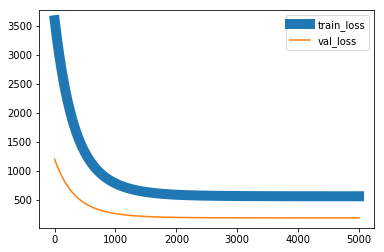

In [110]:
# 損失関数の描画
xlines = np.arange(1, len(scr_iris.loss) + 1)

plt.plot(xlines, scr_iris.loss, linewidth=10, label="train_loss")
plt.plot(xlines, scr_iris.val_loss, label="val_loss")

plt.legend()
plt.show()

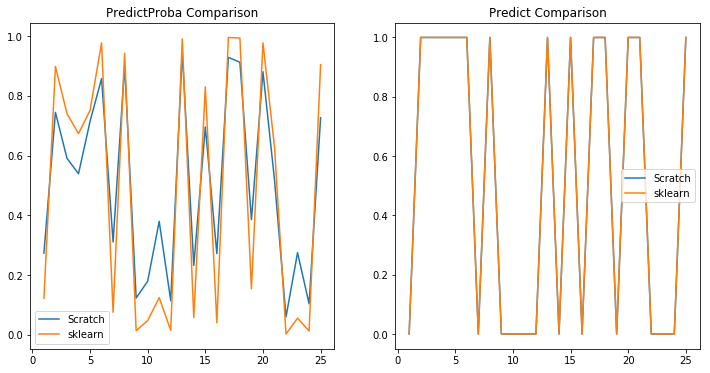

In [113]:
# probaの比較
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

xline = np.arange(1, len(sk_proba) + 1)

axes[0].set_title("PredictProba Comparison")
axes[0].plot(xline, scr_proba, label="Scratch")
axes[0].plot(xline, sk_proba[:, 1], label="sklearn")
axes[0].legend()

axes[1].set_title("Predict Comparison")
axes[1].plot(xline, scr_pred, label="Scratch")
axes[1].plot(xline, sk_pred, label="sklearn")
axes[1].legend()

plt.show()

## 比較すると予測に相違がある。
- 違いは学習率やラムダの違いか？・・・
- 特に確率のところでsklearnのように極値にまでぶれていない感じがある。

> 0823追記
class内_gradient_descentを修正し、損失関数はいい波形になり、予測結果は上記グラフになった。おおよそsklearnと同じ波形になりsklearnとにが学習ができていると思われる。

> 念のためスコアテーブルをdf化してみる

In [115]:
predict_table = pd.DataFrame({"Scratch_predict": scr_pred,
                             "Scratch_proba": scr_proba,
                             "sklearn_predict": sk_pred,
                             "sklearn_proba": sk_proba[:, 1]})

predict_table

,Scratch_predict,Scratch_proba,sklearn_predict,sklearn_proba
0,0,0.273275,0,0.121527
1,1,0.744565,1,0.898158
2,1,0.590886,1,0.740615
3,1,0.538966,1,0.673253
4,1,0.713985,1,0.750911
5,1,0.857517,1,0.977204
6,0,0.310301,0,0.075082
7,1,0.900609,1,0.942625
8,0,0.122840,0,0.013414
9,0,0.178939,0,0.046940


## 【問題7】決定領域の可視化
決定領域を可視化してください。

In [116]:
# 特徴量を2つに絞る。
X2 = df.iloc[:, [2, 3]].values
y2 = df.iloc[:, 4].values

X2_train, X2_test, y2_train, y2_test =  train_test_split(X2, y2, test_size=0.25, random_state=1)
print(X2_train.shape)
print(X2_test.shape)

(75, 2)
(25, 2)


In [117]:
scaler.fit(X2_train)   #後でスケーリングするために使用する平均と標準を計算します。
X2_train_scaler = scaler.transform(X2_train)   # 標準化　センタリングとスケーリングによって標準化を実行する
X2_test_scaler = scaler.transform(X2_test)     # 標準化　センタリングとスケーリングによって標準化を実行する

In [118]:
scr_iris2 = ScratchLogisticRegression(num_iter=5000, 
                                   lr=0.01,
                                   C=1,
                                   no_bias=False, 
                                   verbose=False,
                                   save=False)

scr_iris2.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [119]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスタンスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

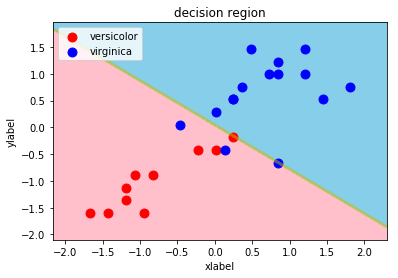

In [120]:
# テストデータ
decision_region(X2_test_scaler, y2_test, scr_iris2)

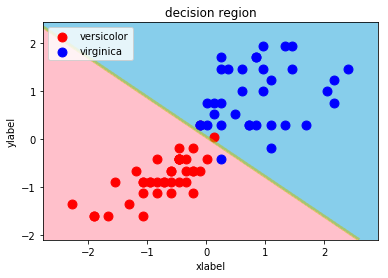

In [121]:
# 訓練データ
decision_region(X2_train_scaler, y2_train, scr_iris2)

## ダメ。

> 0823追記
  散布図上も問題なくなった。しっかり学習できていると判断できる。

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

In [149]:
# np.savezテスト用
scr_iris3 = ScratchLogisticRegression(num_iter=1000, 
                                   lr=0.01,
                                   C=1,
                                   no_bias=False, 
                                   verbose=False,
                                   save=True)   # 重みの保存

scr_iris3.fit(X2_train_scaler, y2_train, X2_test_scaler, y2_test)

In [150]:
npz = np.load("./Update_theta.npy")

npz

array([0.42250366, 1.26767639, 1.85871848])

## class内に組込し、更新されたthetaの保存と読み込みを確認できた。